In [30]:
# ── 固定隨機種子，請放在 import 後、任何資料集/模型建立之前 ──
import random, numpy as np, torch

SEED = 1               # 你想用的種子數
random.seed(SEED)       # Python 內建 random
np.random.seed(SEED)    # NumPy
torch.manual_seed(SEED) # PyTorch CPU
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)      # PyTorch GPU
torch.backends.cudnn.deterministic = True # 讓 cuDNN 算子 deterministic
torch.backends.cudnn.benchmark = False    # 關掉自適應演算法選擇


In [31]:
# 必須先安裝: pip install numpy torch torchvision scikit-learn matplotlib pillow tqdm

%matplotlib inline
import os, random, csv, colorsys, numpy as np, torch
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.metrics import precision_recall_curve, average_precision_score
from torch.utils.data import Dataset, DataLoader, Subset, random_split

# 你的四種模型
from Depth4UNet          import UNet11_4ch as UNet11_ReLU   # RGBD (VGG11+ReLU)
from Depth4UNetGELU      import EnhancedUNet11_4ch as UNet11_GELU  # RGBD (VGG11+GELU)
from UNet                import UNet_4ch   as UNet4_RGBD   # RGBD (原生 U-Net)
from UNetVGG11           import UNet11     as UNet11_RGB   # RGB  (VGG11)

ARCHES = {
    "unet4_rgbd" : dict(cls=UNet4_RGBD,  in_ch=4),
    "vgg11_relu" : dict(cls=UNet11_ReLU, in_ch=4),
    "vgg11_gelu" : dict(cls=UNet11_GELU, in_ch=4),
    "vgg11_rgb"  : dict(cls=UNet11_RGB,  in_ch=3),
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [32]:
class _BaseDS(Dataset):
    def __init__(self, root, crop=256):
        root = Path(root)
        self.crop = crop
        self.img_dir, self.mask_dir = root / "images", root / "gt"
        self.names = sorted(os.listdir(self.img_dir))
    def _crop(self,*arrs):
        h,w = arrs[0].shape[:2]; ch=cw=self.crop
        top, left = random.randint(0,h-ch), random.randint(0,w-cw)
        return [a[top:top+ch,left:left+cw] for a in arrs]

class DS_RGB(_BaseDS):
    MEAN = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    STD  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    def __getitem__(self,i):
        n=self.names[i]
        rgb = np.asarray(Image.open(self.img_dir/n).convert("RGB"))
        msk = np.asarray(Image.open(self.mask_dir/n).convert("L"))
        rgb,msk=self._crop(rgb,msk)
        rgb=torch.from_numpy(rgb).permute(2,0,1).float()/255.0
        msk=(torch.from_numpy(msk)//255).float().unsqueeze(0)
        rgb=(rgb-self.MEAN)/self.STD
        return rgb,msk

class DS_RGBD(_BaseDS):
    MEAN = torch.tensor([0.485,0.456,0.406,0.5]).view(4,1,1)
    STD  = torch.tensor([0.229,0.224,0.225,0.5]).view(4,1,1)
    def __init__(self,root,crop=256):
        super().__init__(root,crop)
        self.depth_dir = Path(root)/"depth_images"
        self.dmap={f[:-6]:f for f in os.listdir(self.depth_dir) if f.endswith("_depth.png")}
    def __getitem__(self,i):
        n=self.names[i]; stem,_=os.path.splitext(n)
        rgb = np.asarray(Image.open(self.img_dir/n).convert("RGB"))
        depth = np.asarray(Image.open(self.depth_dir/self.dmap.get(stem,"")).convert("L")) \
                if stem in self.dmap else np.zeros(rgb.shape[:2],np.uint8)
        msk = np.asarray(Image.open(self.mask_dir/n).convert("L"))
        rgb,depth,msk=self._crop(rgb,depth[...,None],msk)
        rgb=torch.from_numpy(rgb).permute(2,0,1).float()/255.0
        depth=torch.from_numpy(depth).permute(2,0,1).float()/255.0
        x=torch.cat([rgb,depth],0); x=(x-self.MEAN)/self.STD
        msk=(torch.from_numpy(msk)//255).float().unsqueeze(0)
        return x,msk
    def __len__(self): return len(self.names)



In [41]:
# ✅ 修改成你的實際路徑
ROOT = r"E:/論文/空拍地圖語意分割/Depth4UNet/AerialImageDataset/train"
VAL_IDX_NPY = "val_idx.npy"   # 首次執行會自動產生
CHECKPOINTS = [
    (r"E:/論文/空拍地圖語意分割/Depth4UNet/checkpoints/best_traditional_unet4ch.pth",  "UNet+Depth",       "unet4_rgbd"),
    (r"E:\論文\空拍地圖語意分割\Depth4UNet\train\checkpoints\best_unet4ch(RELU).pth",  "TernausNet+Depth",  "vgg11_relu"),
    (r"E:\論文\空拍地圖語意分割\Depth4UNet\train\checkpoints\best_unet4ch(Enhanced_UNet11_4ch).pth",  "Depth4UNet",  "vgg11_gelu"),

]
BATCH_SIZE = 4


In [42]:
def get_loader(root, in_ch, idx_file, crop=256, bs=4):
    base = DS_RGBD if in_ch==4 else DS_RGB
    full = base(root,crop)
    if os.path.exists(idx_file):
        idx = np.load(idx_file); val_ds=Subset(full,idx)
    else:
        v=int(0.1*len(full))
        _,val_ds=random_split(full,[len(full)-v,v],generator=torch.Generator().manual_seed(0))
        np.save(idx_file, np.array(val_ds.indices))
    return DataLoader(val_ds,batch_size=bs,shuffle=False,num_workers=0)

import torch.nn as nn

def add_missing_bias(module: nn.Module):
    """
    遍歷整個 model，若某個 nn.Conv2d / nn.ConvTranspose2d 沒有 bias，
    就動態加上一個零初始化的 bias 參數，使其能對應舊 checkpoint。
    """
    for name, m in module.named_modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)) and m.bias is None:
            b = nn.Parameter(torch.zeros(m.out_channels, device=m.weight.device))
            m.register_parameter("bias", b)      # 動態掛進 module
            # 注意：不用修改 m.register_parameter 的 return 值



Loading UNet+Depth from E:/論文/空拍地圖語意分割/Depth4UNet/checkpoints/best_traditional_unet4ch.pth …
UNet+Depth: matched 46 / 46 layers

Loading TernausNet+Depth from E:\論文\空拍地圖語意分割\Depth4UNet\train\checkpoints\best_unet4ch(RELU).pth …
TernausNet+Depth: matched 56 / 56 layers

Loading Depth4UNet from E:\論文\空拍地圖語意分割\Depth4UNet\train\checkpoints\best_unet4ch(Enhanced_UNet11_4ch).pth …
Depth4UNet: matched 351 / 351 layers


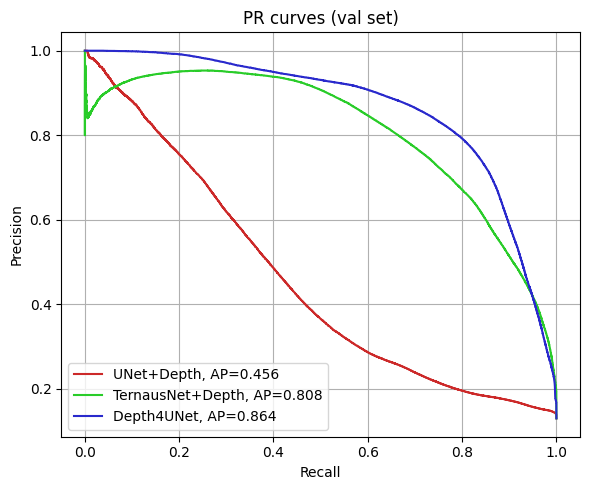

In [45]:
# ------------------------------------------------------------
# 0. 固定 seed + 預先「存起來」目前 RNG 狀態
# ------------------------------------------------------------
SEED = 100
import random, numpy as np, torch, colorsys, matplotlib.pyplot as plt
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic, torch.backends.cudnn.benchmark = True, False

### ← 新：把三個 RNG state 都存起來，之後每模型 restore
py_state   = random.getstate()
np_state   = np.random.get_state()
torch_state= torch.get_rng_state()
cuda_state = torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None
# ------------------------------------------------------------

def palette(n): return [colorsys.hsv_to_rgb(i/n,0.8,0.8) for i in range(n)]

loaders = {}
plt.figure(figsize=(6,5))
for (ckpt, label, arch), color in zip(CHECKPOINTS, palette(len(CHECKPOINTS))):
    info = ARCHES[arch]
    if info["in_ch"] not in loaders:
        loaders[info["in_ch"]] = get_loader(ROOT, info["in_ch"],
                                            VAL_IDX_NPY, crop=256, bs=BATCH_SIZE)
    ld = loaders[info["in_ch"]]

    # -------- 1. 建模型 --------
    print(f"\nLoading {label} from {ckpt} …")
    if arch == "vgg11_gelu":
        model = UNet11_GELU().to(device)                # ⭐ 不傳 pretrained
    elif arch == "vgg11_relu":
        model = UNet11_ReLU().to(device)                # ⭐ 不傳 pretrained
    else:
        try:                                            # ⭐ 一般模型若支援 pretrained
            model = info["cls"](pretrained=False).to(device)
        except TypeError:                               # ⭐ 不支援就退回空參數
            model = info["cls"]().to(device)
    add_missing_bias(model)

    # -------- 2. 載入權重（weights_only=True）--------
    state_all   = torch.load(ckpt, map_location=device, weights_only=True)
    model_state = model.state_dict()
    compat = {k:v for k,v in state_all.items()
              if k in model_state and v.shape == model_state[k].shape}
    model_state.update(compat)
    model.load_state_dict(model_state, strict=False)
    print(f"{label}: matched {len(compat)} / {len(state_all)} layers")

    # -------- 3. 在每個模型開始驗證前，把 RNG 狀態「撥回原點」--------
    ### ← 這 7 行確保每次裁切序列都一樣
    random.setstate(py_state)
    np.random.set_state(np_state)
    torch.set_rng_state(torch_state)
    if cuda_state is not None:
        torch.cuda.set_rng_state_all(cuda_state)
    # --------------------------------------------------------------------

    # -------- 4. 評估 & 收集 PR --------
    y_true, y_score = [], []
    model.eval()
    with torch.no_grad():
        for x, y in ld:                    # 會裁到同一批 patch
            y_score.append(torch.sigmoid(model(x.to(device))).cpu())
            y_true.append(y)
    y_true  = torch.cat(y_true).numpy().ravel()
    y_score = torch.cat(y_score).numpy().ravel()

    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.plot(recall, precision, color=color, label=f"{label}, AP={ap:.3f}",)

plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("PR curves (val set)")
plt.grid(); plt.legend(); plt.tight_layout()




========== Run (seed=100) ==========
UNet+Depth          AP = 0.4564
TernausNet+Depth    AP = 0.8797
Depth4UNet          AP = 0.9430


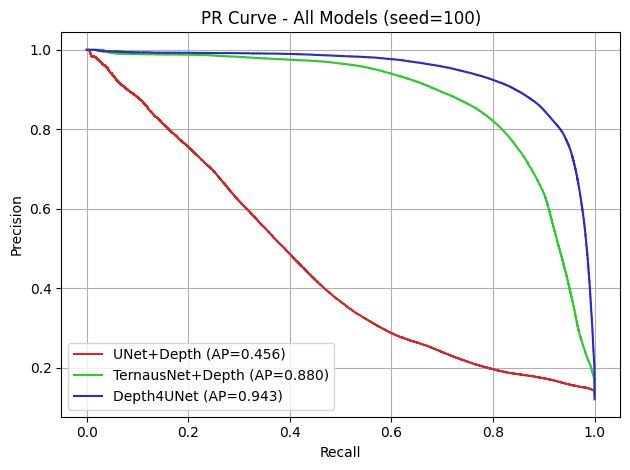

In [ ]:
# 只跑 seed=100
SEED = 100
print(f"\n========== Run (seed={SEED}) ==========")

# 固定 RNG
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic, torch.backends.cudnn.benchmark = True, False

# 重建 DataLoader（每 run 皆更新隨機裁切）
loaders = {}
for (_, _, arch) in CHECKPOINTS:
    in_ch = ARCHES[arch]["in_ch"]
    if in_ch not in loaders:
        loaders[in_ch] = get_loader(ROOT, in_ch, VAL_IDX_NPY,
                                    crop=CROP_SIZE, bs=BATCH_SIZE)

# PR 曲線初始化
plt.figure()
colors = palette(len(CHECKPOINTS))

# 逐模型評估與繪圖
for (ckpt, label, arch), color in zip(CHECKPOINTS, colors):
    info = ARCHES[arch]
    ld   = loaders[info["in_ch"]]

    # 建模型
    cls = info["cls"]
    try:
        model = cls(pretrained=False).to(device)
    except TypeError:
        model = cls().to(device)
    add_missing_bias(model)

    # 載權重（partial match）
    state_all = torch.load(ckpt, map_location=device, weights_only=True)
    ms = model.state_dict()
    compat = {k:v for k,v in state_all.items() if k in ms and v.shape==ms[k].shape}
    ms.update(compat)
    model.load_state_dict(ms, strict=False)

    # 評估
    y_true, y_score = [], []
    model.eval()
    with torch.no_grad():
        for x, y in ld:
            prob = torch.sigmoid(model(x.to(device))).cpu()
            y_score.append(prob)
            y_true.append(y)
    y_true  = torch.cat(y_true).numpy().ravel()
    y_score = torch.cat(y_score).numpy().ravel()

    # AP + PR 曲線
    ap = average_precision_score(y_true, y_score)
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    plt.plot(recall, precision, label=f"{label} (AP={ap:.3f})", color=color)

    # F1-score（用 PR 曲線上 max F1）
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    f1_max = np.max(f1_scores)

    # mIoU（二值化後計算 IoU）
    y_pred = (y_score >= 0.5).astype(np.uint8)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / (union + 1e-8)

    # 印出
    print(f"{label:18}  AP = {ap:.4f}   F1 = {f1_max:.4f}   mIoU = {iou:.4f}")

# 圖表輸出
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR Curve - All Models (seed={SEED})")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig(f"prcurve_seed{SEED}_all.png")
plt.show()
